<a href="https://colab.research.google.com/github/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/blob/main/Twitter_Sentiment_Analysis_Model_With_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install PySastrawi==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# Mengimpor library untuk preprocessing data
import pandas as pd
import numpy as np
import string
import nltk
import pickle
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for word embedding and model building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# for evaluation on test data
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#Membuat fungsi load_data untuk membuka file csv hasil crawling data
url= "https://github.com/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/blob/main/Dataset/Data-hasil-klasifikasi-positif-negatif.xlsx?raw=true"

In [22]:
df = pd.read_excel(url)
df.sample(10)

,tweetcreatedts,username,text,source,tweet_clean,tweet_english,klasifikasi
1713,26/02/2023 08:27,Beritasatu,anies gunakan tagline heru budi sukses jakarta...,beritasatu,anies gunakan tagline heru budi sukses jakarta...,anies use the heru budi sukses jakarta tagline...,Positif
263,26/02/2023 03:50,agussalamun99,saya minta penanganan kasus mario di tarik ke ...,Twitter Web App,saya minta penanganan kasus mario di tarik ke ...,i ask that the handling of the mario case be w...,Positif
1611,26/02/2023 10:01,BujangeGR,ciamis kotaku ganjar pilihanku pesta rakyat ga...,Twitter for iPhone,ciamis kotaku ganjar pilihanku pesta rakyat ga...,ciamis kotaku ganjar my choice the people's pa...,Positif
1752,22/02/2023 11:54,IDCorner,heru budi soal jokowi mau normalisasi ciliwung...,IDCorner.Co.iD,heru budi soal jokowi mau normalisasi ciliwung...,heru budi about jokowi wants to normalize cili...,Positif
2207,28/02/2023 22:33,ramden0810,polri lingakaran anak anak ingusan yang kuran...,Twitter for Android,polri lingakaran anak anak ingusan yang kurang...,polri lingkaran burik children who lack their ...,Positif
2284,28/02/2023 21:57,Anstsya97356785,dr awal org ini muncul gua udah ga percaya si ...,Twitter for Android,dr awal org ini muncul gua udah ga percaya si ...,from the beginning this person appeared i didn...,Positif
189,26/02/2023 11:58,Herudin1010,setuju gak si es kopi susu keluarga famimart t...,Twitter Web App,setuju gak si es kopi susu keluarga famimart t...,agree or not the ice coffee milk family famima...,Positif
1003,26/02/2023 05:59,PutraHunian,pendukung aniesbaswedan pun gak bener,Twitter Web App,pendukung aniesbaswedan pun gak bener,aniesbaswedan supporters are not correct,Negatif
1871,28/02/2023 23:55,ZakiAdzkia,dpr polri djp bea cukai edun euy,Twitter for iPhone,dpr polri djp bea cukai edun euy,dpr police dgt customs edun euy,Negatif
638,23/02/2023 14:42,urpremium,open yt premium bulan cuma rb bukan bajakan a...,Twitter for Android,open yt premium bulan cuma rb bukan bajakan as...,open yt premium moon only rb not pirated origi...,Positif


In [23]:
#Menampilkan berapa banyak baris dan kolom
df.shape 

(2328, 7)

In [24]:
#Menampilkan daftar kolom, jumlah null, dan tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweetcreatedts  2328 non-null   object
 1   username        2328 non-null   object
 2   text            2328 non-null   object
 3   source          2328 non-null   object
 4   tweet_clean     2328 non-null   object
 5   tweet_english   2328 non-null   object
 6   klasifikasi     2328 non-null   object
dtypes: object(7)
memory usage: 127.4+ KB


In [25]:
# calculating missingess of entire DF
missingness = df.isnull().sum().sum() / df.count().sum()
print('Overall Missingness of df is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(df).head(10)

Overall Missingness of df is: 0.00%


,Total,Percent
tweetcreatedts,0,0.0
username,0,0.0
text,0,0.0
source,0,0.0
tweet_clean,0,0.0
tweet_english,0,0.0
klasifikasi,0,0.0


In [26]:
#Hapus baris yang memiliki nilai null
df.dropna(inplace=True)

In [27]:
#Lihat duplikat data
duplCheck = df.duplicated().sum()
duplCheck

28

In [28]:
#Remove duplicate
df = df.reset_index(drop=True).drop_duplicates(subset='text', keep="last", ignore_index=True)

In [30]:
#Mneghitung jumlah klasifikasi
df["klasifikasi"].value_counts()

Positif    1225
Negatif    1069
Name: klasifikasi, dtype: int64

In [31]:
#Membuat datagrame baru yang terdiri dari kolom tweet dan klasifikasi saja
df = pd.DataFrame(df[['text', 'klasifikasi']])

### Case Folding, Menghilangkan tanda baca dan karakter yang tidak diperlukan

In [32]:
# membuat fungsi untuk case folding
def casefolding(tweet_df):
    pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    pattern1 = re.compile(r'pic.twitter.com/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweet_df = re.sub(pattern,' ',tweet_df) #remove urls if any
    tweet_df = re.sub(pattern1,' ',tweet_df)
    #Convert to lower case
    tweet_df = tweet_df.lower()                                
     #Convert www.* or https?://*
    tweet_df = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet_df) 
    #Convert @username to AT_USER
    tweet_df = re.sub('@+','',tweet_df)
     #Remove additional white spaces
    tweet_df = re.sub('[\s]+', ' ', tweet_df)
    #Replace #word with word
    tweet_df  = re.sub(r'#([^\s]+)', r'\1', tweet_df )
    #remove symbols
    tweet_df = re.sub(r'[^.,a-zA-Z0-9 \n\.]',' ',tweet_df)
    tweet_df = re.sub(r'[-+]?[0-9]+', '', tweet_df)  
    tweet_df = tweet_df.replace(',',' ').replace('.',' ')          
    tweet_df = re.sub(r'[^\w\s]', '', tweet_df)    
    #trim             
    tweet_df = tweet_df.strip('\'"')
    return tweet_df

### Normalisasi, Merubah kata menjadi baku

In [33]:
key_norm = pd.read_csv('https://raw.githubusercontent.com/FaddliLWibowo/Twitter-Sentiment-Analysis-with-Streamlit/main/Dataset/kamus-slang-ind.csv', encoding='ISO-8859-1')

def text_normalize(tweet_df):
    tweet_df = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0]
    if (key_norm['singkat'] == word).any()
    else word for word in tweet_df.split()
    ])
    tweet_df = str.lower(tweet_df)
    return tweet_df

### Stopword dan Tokenization, kata umum yang tidak memberikan informasi penting/tidak memiliki makna

In [34]:
stopwords_ind = stopwords.words('indonesian')
more_stopword = ['terusmajubersamaprabowo', 'mendingprabowo', 'prabowopresiden', 'prabowopersatuanindonesia', 'prabowosubianto']
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_word(tweet_df):
    clean_words = []
    tweet_df = tweet_df.split()
    for word in tweet_df:
        if word not in stopwords_ind:
            clean_words.append(word)
    return " ".join(clean_words)

### Stemming, berfungsi untuk menghilangkan imbuhan dan kembali ke kata dasar

In [35]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# membuat fungsi untuk stemming bahasa indonesia
def stemming(tweet_df):
    tweet_df = stemmer.stem(tweet_df)
    return tweet_df

### Text preprocessing pipeline

In [36]:
# membuat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing(tweet_df):
    tweet_df = casefolding(tweet_df)
    tweet_df = text_normalize(tweet_df)
    tweet_df = remove_stop_word(tweet_df)
    tweet_df = stemming(tweet_df)
    return tweet_df

df['text'] = df['text'].apply(text_preprocessing)

In [37]:
df.to_csv("Data-hasil-preprocessing.csv",encoding='utf-8',index=False)

### Klasifikasi Menngunakan Naive Bayes

In [38]:
newData = pd.read_csv('Data-hasil-preprocessing.csv',encoding='ISO-8859-1')

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer().fit(newData['text']) 
bow_transformer.vocabulary_

{'buntut': 830,
 'aniaya': 235,
 'rafaelaluntrisambodo': 4226,
 'mariodandysatrio': 3105,
 'psikolog': 4159,
 'forensik': 1480,
 'nilai': 3546,
 'sikap': 4774,
 'brutal': 782,
 'mds': 3169,
 'laku': 2801,
 'pengaruh': 3860,
 'salah': 4483,
 'satu': 4561,
 'pola': 4010,
 'asuh': 368,
 'takar': 5032,
 'risk': 4389,
 'assessment': 364,
 'tingkat': 5229,
 'mandiri': 3072,
 'finansial': 1456,
 'sosial': 4871,
 'mariodandy': 3102,
 'kepala': 2500,
 'polisi': 4019,
 'daerah': 1057,
 'metro': 3258,
 'jaya': 2199,
 'pimpin': 3947,
 'langsung': 2823,
 'gelar': 1606,
 'perkara': 3893,
 'mario': 3099,
 'dandy': 1083,
 'david': 1099,
 'latumahina': 2848,
 'poldametrojaya': 4014,
 'mariodandysatriyo': 3106,
 'agnes': 57,
 'agnesgraciaharyanto': 60,
 'pajak': 3692,
 'pajakkitauntukpejabat': 3698,
 'pajakkitauntukbelirubicon': 3695,
 'tetap': 5177,
 'sangka': 4529,
 'peran': 3871,
 'shane': 4724,
 'lukas': 2974,
 'ungkap': 5412,
 'shanelukas': 4725,
 'prayfordavid': 4105,
 'problematik': 4136,
 'kelah

In [40]:
tokens = bow_transformer.get_feature_names()
print(tokens)

['aalona', 'aan', 'aapa', 'aas', 'ab', 'abal', 'abang', 'abas', 'abby', 'abdi', 'abdul', 'abdulfickarhadjar', 'abis', 'abram', 'abu', 'abud', 'abuse', 'abw', 'acara', 'account', 'aceh', 'achika', 'achmad', 'achmadi', 'ada', 'adaapadisihite', 'adaapahariini', 'adab', 'adakan', 'adam', 'adat', 'address', 'adearysyam', 'adegan', 'adekmu', 'adik', 'adil', 'adilmakmur', 'adipala', 'admin', 'administrasi', 'adopsi', 'adu', 'adua', 'adudomba', 'aduh', 'aespastconcertsynk', 'afrizalhady', 'ag', 'aga', 'agam', 'agama', 'agen', 'agenda', 'agens', 'agh', 'agn', 'agnes', 'agnesdavid', 'agnesgracia', 'agnesgraciaharyanto', 'agnez', 'agraria', 'ags', 'agung', 'agus', 'agusharimurtiyudhoyono', 'aguskurniawan', 'agusnupatria', 'agusnurpatria', 'agusyudhoyono', 'ah', 'aha', 'aher', 'ahli', 'ahmad', 'ahmadheryawan', 'ahmadmuzani', 'ahmadoxavian', 'ahmadsyaikhu', 'ahok', 'ahyeon', 'ahypimpinperubahan', 'ai', 'aib', 'aiman', 'aimanwitjaksono', 'aimaryati', 'ainul', 'ainulyaqin', 'aipda', 'aiptu', 'air', '

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
text_bow = bow_transformer.transform(newData['text'])

  (0, 235)	1
  (0, 830)	1
  (0, 3105)	1
  (0, 4226)	1
  (1, 235)	2
  (1, 364)	1
  (1, 368)	1
  (1, 782)	1
  (1, 1456)	1
  (1, 1480)	1
  (1, 2801)	1
  (1, 3072)	2
  (1, 3102)	1
  (1, 3169)	1
  (1, 3546)	1
  (1, 3860)	1
  (1, 4010)	1
  (1, 4159)	1
  (1, 4389)	1
  (1, 4483)	2
  (1, 4561)	2
  (1, 4774)	1
  (1, 4871)	1
  (1, 5032)	1
  (1, 5229)	1
  :	:
  (2290, 809)	1
  (2290, 1492)	1
  (2290, 2014)	1
  (2290, 4019)	1
  (2290, 4327)	1
  (2290, 4659)	1
  (2291, 1492)	1
  (2291, 2014)	1
  (2291, 3657)	2
  (2291, 3701)	1
  (2291, 4019)	1
  (2291, 4327)	1
  (2291, 4483)	1
  (2291, 5139)	1
  (2291, 5344)	1
  (2292, 1914)	1
  (2292, 4019)	1
  (2292, 5220)	1
  (2292, 5224)	1
  (2292, 5268)	1
  (2293, 1892)	1
  (2293, 1911)	1
  (2293, 3432)	1
  (2293, 4019)	1
  (2293, 5543)	1


In [42]:
X = text_bow.toarray()
print(X)
X.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(2294, 5689)

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer().fit(text_bow)
print(tfidf_transformer)

tweet_tfidf=tfidf_transformer.transform(text_bow)
print(tweet_tfidf)
print(tweet_tfidf.shape) 

TfidfTransformer()
  (0, 4226)	0.47229405400177193
  (0, 3105)	0.45279805797931244
  (0, 830)	0.66995508346006
  (0, 235)	0.35081680602667636
  (1, 5229)	0.15995664832493667
  (1, 5032)	0.2197758066709895
  (1, 4871)	0.15995664832493667
  (1, 4774)	0.17989636777362095
  (1, 4561)	0.303361834057266
  (1, 4483)	0.2754286911163683
  (1, 4389)	0.23143979482337013
  (1, 4159)	0.20508091947998244
  (1, 4010)	0.19983608722230523
  (1, 3860)	0.21150007537468585
  (1, 3546)	0.16379793713227794
  (1, 3169)	0.18514120003129816
  (1, 3102)	0.07859514715477472
  (1, 3072)	0.4230001507493717
  (1, 2801)	0.12999721306323217
  (1, 1480)	0.19983608722230523
  (1, 1456)	0.23143979482337013
  (1, 782)	0.18514120003129816
  (1, 368)	0.19156035592600157
  (1, 364)	0.23143979482337013
  (1, 235)	0.19706973320691804
  :	:
  (2290, 4327)	0.23986540500667988
  (2290, 4019)	0.18407469578447166
  (2290, 2014)	0.19914662885495524
  (2290, 1492)	0.4380501526698839
  (2290, 809)	0.3671889728516931
  (2290, 277)	0.4

In [44]:
dd=pd.DataFrame(data=tweet_tfidf.toarray(),columns=tokens)

,aalona,aan,aapa,aas,ab,abal,abang,abas,abby,abdi,...,zionis,ziyech,zodiak,zoel,zoey,zonajajan,zonauang,zubair,zulhas,zulkiflihasan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
from sklearn.model_selection import train_test_split

x_latih, x_tes, y_latih, y_tes = train_test_split(X, df.klasifikasi, test_size=0.20, random_state=42)

In [46]:
print(x_latih.shape) 
print(x_tes.shape)
print(y_latih.shape)
print(y_tes.shape)

(1835, 5689)
(459, 5689)
(1835,)
(459,)


In [47]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(x_latih,y_latih)

test time:  0.015s
accuracy:   0.723
              precision    recall  f1-score   support

     Negatif       0.67      0.82      0.74       215
     Positif       0.80      0.64      0.71       244

    accuracy                           0.72       459
   macro avg       0.73      0.73      0.72       459
weighted avg       0.74      0.72      0.72       459



Text(33.0, 0.5, 'Label sebenarnya')

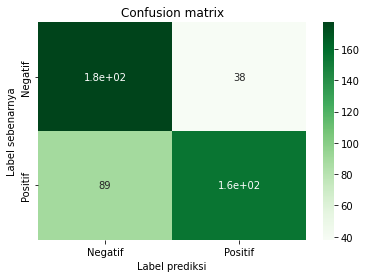

In [50]:
from time import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from pandas import DataFrame

t = time()
y_pred = model.predict(x_tes)

test_time = time() - t
print("test time:  %0.3fs" % test_time)

score1 = metrics.accuracy_score(y_tes, y_pred)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(y_tes, y_pred, target_names=['Negatif', 'Positif']))

columns = ['Negatif', 'Positif']
confm = confusion_matrix(y_tes, y_pred)
df_cm = DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Greens', annot=True)
ax.set_title('Confusion matrix')
ax.set_xlabel('Label prediksi')
ax.set_ylabel('Label sebenarnya')

In [51]:
user_data = ["keren prabowo menang oleh suara sultra calon"]
print(user_data)

['keren prabowo menang oleh suara sultra calon']


In [52]:
test_1_unseen =  bow_transformer.transform(user_data)
data=test_1_unseen.toarray()
print("diubah menjadi array: \n ",data)

diubah menjadi array: 
  [[0 0 0 ... 0 0 0]]


In [53]:
prediction_unseen = model.predict(data)
print(prediction_unseen)

['Positif']


### Klasifikasi menggunakan LSTM

In [55]:
newDataLSTM = pd.read_csv('Data-hasil-preprocessing.csv',encoding='ISO-8859-1')

In [56]:
df = df[(newDataLSTM["text"].notna()) & (newDataLSTM["text"] != "")]

# use 80% of the data for training, and set aside 20% for testing
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(index=train_df.index)

In [57]:
# further split the training set into training and validation set
X = train_df.text
y = train_df.klasifikasi
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)

In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
nunique_words = len(tokenizer.word_index) + 1
print("Number of Unique Words: {}".format(nunique_words))

Number of Unique Words: 5100


In [59]:
# saving tokenizer
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train))
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=X_train.shape[1])
y_train = y_train.replace({"Negatif": 0, "Positif": 1})
y_test = y_test.replace({"Negatif": 0, "Positif": 1})

In [61]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=nunique_words, output_dim=128),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
mc_callback = ModelCheckpoint(
    filepath="lstm_model-{epoch:02d}.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True)
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    # callbacks=[mc_callback],
    batch_size=128,
    verbose=2)

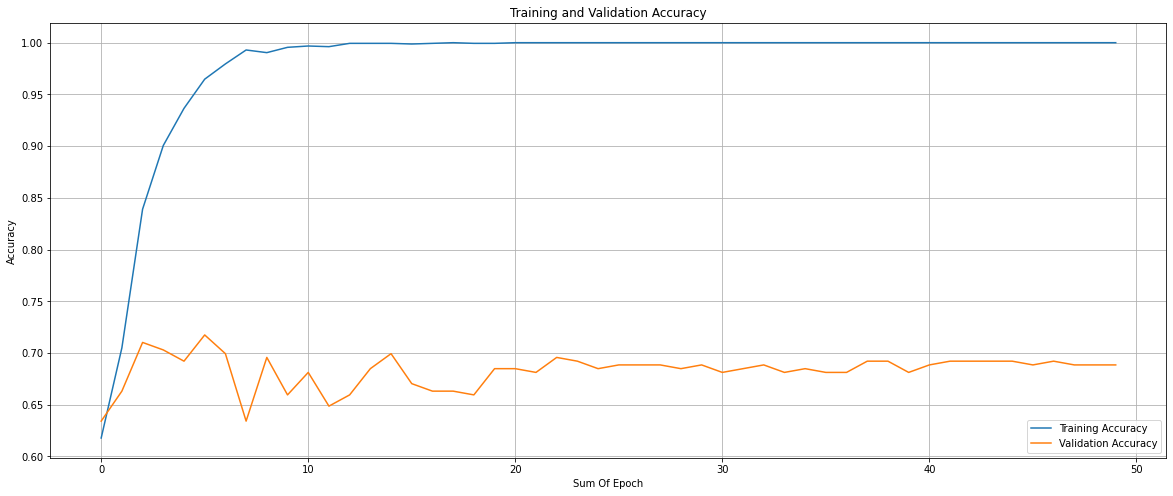

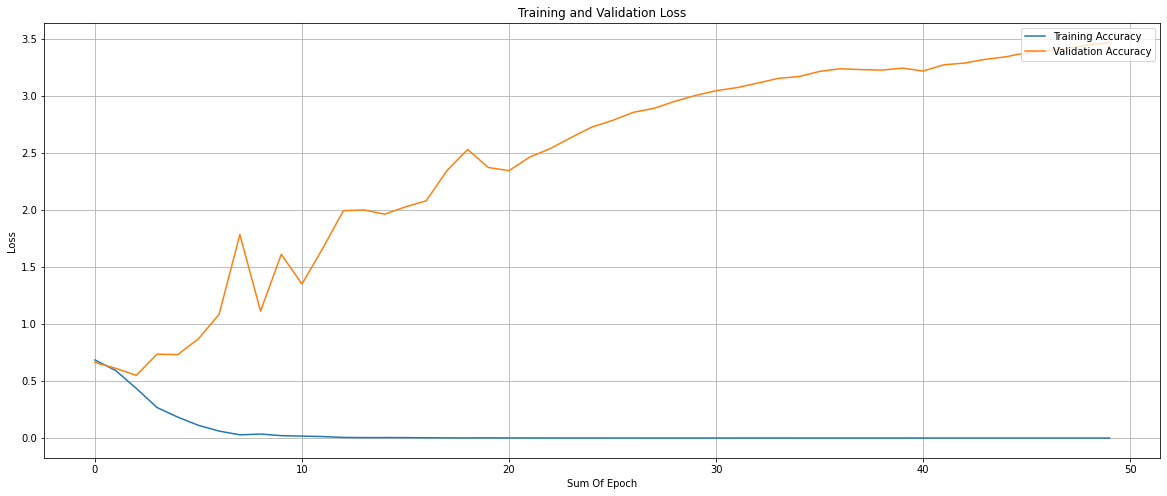

In [63]:
# Plot Training & Validation Accuracy Values
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Sum Of Epoch')
plt.grid(True)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

# Plot Training & Validation Loss Values
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Sum Of Epoch')
plt.grid(True)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()

### Evaluation on test data

In [64]:
# Evaluate
evaluate = model.evaluate(X_test, y_test, verbose=1)
print('Loss: ', evaluate[0])
print('Accuracy: ', evaluate[1]*100, ' %')

9/9 [==============================] - 0s 25ms/step - loss: 3.4638 - accuracy: 0.6884
Loss:  3.4638490676879883
Accuracy:  68.84058117866516  %


In [65]:
model.save('twitter-sentiment-analysis-model-lstm.h5')

In [66]:
newmodel = load_model("twitter-sentiment-analysis-model-lstm.h5")

In [67]:
with open("/content/tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

In [68]:
sequences = pad_sequences(
    tokenizer.texts_to_sequences(newDataLSTM["text"]), maxlen=X_train.shape[1]
)
score = newmodel.predict(sequences)
newDataLSTM["score"] = score
newDataLSTM["pred_klasifikasi"] = newDataLSTM["score"].apply(
    lambda x: "Positif" if x >= 0.50 else "Negatif"
)

72/72 [==============================] - 2s 26ms/step


In [69]:
accuracy_score(newDataLSTM["klasifikasi"], newDataLSTM["pred_klasifikasi"])

0.9075850043591979

In [70]:
tn, fp, fn, tp = confusion_matrix(
    newDataLSTM["klasifikasi"], newDataLSTM["pred_klasifikasi"]
).ravel()
tnr = tn / (tn + fp)
tpr = tp / (tp + fn)
print("True Negative Rate: {:.3f}".format(tnr))
print("True Positive Rate: {:.3f}".format(tpr))

True Negative Rate: 0.895
True Positive Rate: 0.918
